In [12]:
# !pip install tensorflow_addons

In [1]:
import tensorflow as tf
from tensorflow import keras
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
# Define the directory containing the preprocessed images
data_dir = 'RandaugmentSplitMonkeypoxSkinImageDataset'

num_classes = 4
input_shape = (128, 128, 3)

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

C:\Users\templ\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
input_shape = (128, 128, 3)
# Define the size of the images
img_size = (128, 128)

# Define the batch size
batch_size = 128

In [4]:
train_path = os.path.join(data_dir, "train")
test_path = os.path.join(data_dir, "test")
validation_path = os.path.join(data_dir, "val")

In [5]:

# # Define the data generators for the training, validation, and test sets

# from keras.preprocessing.image import ImageDataGenerator

# # Define the data generators for the training, validation, and test sets
# # Define the data generators for the training, validation, and test sets
# train_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2RGB))
# train_generator = train_datagen.flow_from_directory(
#         os.path.join(data_dir, 'train'),
#         target_size=img_size,
#         batch_size=batch_size,
#         class_mode='sparse')

# val_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2RGB))
# val_generator = val_datagen.flow_from_directory(
#         os.path.join(data_dir, 'val'),
#         target_size=img_size,
#         batch_size=batch_size,
#         class_mode='sparse')

# test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2RGB))
# test_generator = test_datagen.flow_from_directory(
#         os.path.join(data_dir, 'test'),
#         target_size=img_size,
#         batch_size=batch_size,
#         class_mode='sparse')



In [6]:
# # Load your own dataset here
# train_path = os.path.join(data_dir, 'train')
# test_path = os.path.join(data_dir, 'test')
# num_classes = len(os.listdir(train_path))
# input_shape = (img_size[0], img_size[1], 3)

# train_dataset = train_generator
# val_dataset = val_generator
# test_dataset = test_generator
# (x_train, y_train), (x_val, y_val), (x_test, y_test) = train_dataset.next(), val_dataset.next(), test_dataset.next()
# print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
# print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

In [7]:
# Define the data generators for the training, validation, and test sets
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255, validation_split=0.1
)

test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)

train_dataset = train_datagen.flow_from_directory(
    train_path, target_size=input_shape[:2], batch_size=batch_size, class_mode="sparse", subset="training"
)

val_dataset = train_datagen.flow_from_directory(
    train_path, target_size=input_shape[:2], batch_size=batch_size, class_mode="sparse", subset="validation"
)

test_dataset = test_datagen.flow_from_directory(
    test_path, target_size=input_shape[:2], batch_size=batch_size, class_mode="sparse"
)

x_train, y_train = train_dataset.next()
x_val, y_val = val_dataset.next()
x_test, y_test = test_dataset.next()
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

Found 553 images belonging to 4 classes.
Found 60 images belonging to 4 classes.
Found 81 images belonging to 4 classes.
x_train shape: (128, 128, 128, 3) - y_train shape: (128,)
x_test shape: (81, 128, 128, 3) - y_test shape: (81,)


In [8]:
# Set hyperparameters
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 3
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [9]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [10]:
# Implement multilayer perceptron (MLP)
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [11]:
# Implement patch creation as a layer
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


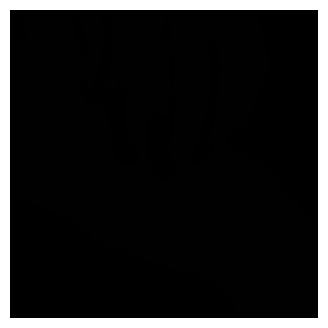

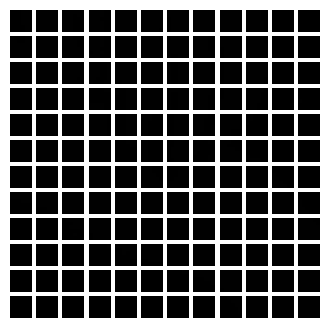

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [13]:
# Implement the patch encoding layer
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [14]:
# Build the ViT model
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model
vit_classifier = create_vit_classifier()

In [15]:
# Compile, train, and evaluate the mode
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_dir = "checkpoints"
    checkpoint_file = "checkpoint"
    checkpoint_path = os.path.join(checkpoint_dir, checkpoint_file)

    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_val, y_val),
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_path)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return model, history
model, history = run_experiment(vit_classifier)

Epoch 1/3
1/1 [==============================] - 20s 20s/step - loss: 3.4115 - accuracy: 0.1953 - top-5-accuracy: 1.0000 - val_loss: 11.7546 - val_accuracy: 0.5000 - val_top-5-accuracy: 1.0000
Epoch 2/3
1/1 [==============================] - 6s 6s/step - loss: 9.1669 - accuracy: 0.5859 - top-5-accuracy: 1.0000 - val_loss: 8.6207 - val_accuracy: 0.4000 - val_top-5-accuracy: 1.0000
Epoch 3/3
3/3 [==============================] - 1s 351ms/step - loss: 8.2555 - accuracy: 0.5679 - top-5-accuracy: 1.0000
Test accuracy: 56.79%
Test top 5 accuracy: 100.0%


In [30]:
import matplotlib.pyplot as plt

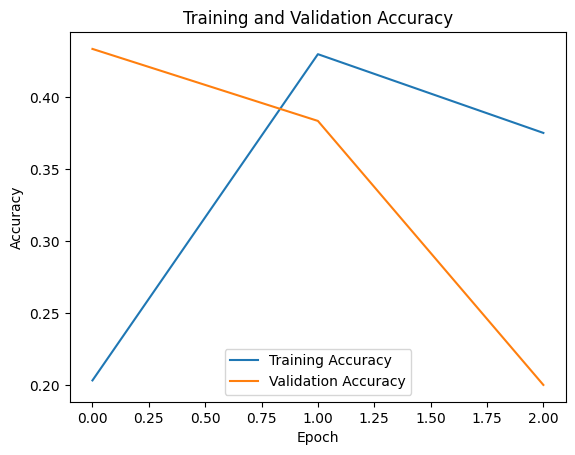

In [31]:
# Plot the training and validation accuracy and loss
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

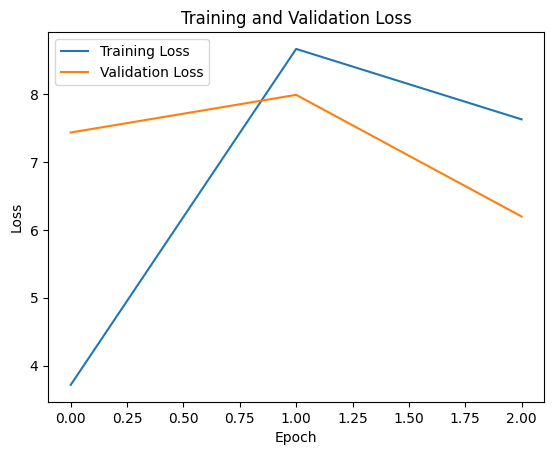

In [32]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [35]:
# Evaluate the model on the test set
test_acc = model.evaluate(test_dataset)[1]* 100
print("Test accuracy: {:.2f}%".format(test_acc))

1/1 [==============================] - 2s 2s/step - loss: 6.8897 - accuracy: 0.4938 - top-5-accuracy: 1.0000
Test accuracy: 49.38%


In [16]:
from sklearn.metrics import classification_report

# Use the predict() method to get the predicted labels for the test data
# Use the model to make predictions on the test data
y_pred_prob = model.predict(test_dataset)

# Convert the predicted probabilities to class indices
y_pred = np.argmax(y_pred_prob, axis=1)

# Print the classification report
print(classification_report(y_test, y_pred))


1/1 [==============================] - 2s 2s/step
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        12
         1.0       0.00      0.00      0.00        10
         2.0       0.51      0.93      0.66        29
         3.0       0.68      0.63      0.66        30

    accuracy                           0.57        81
   macro avg       0.30      0.39      0.33        81
weighted avg       0.43      0.57      0.48        81



C:\Users\templ\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\templ\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\templ\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [17]:
# Save the trained model to a file
model.save('vitRandVit.h5')

In [38]:
from sklearn.metrics import confusion_matrix

# Use the model to make predictions on the test data
y_pred = np.argmax(model.predict(test_dataset), axis=1)

# Create the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print(conf_mat)


1/1 [==============================] - 2s 2s/step
[[ 0  0  5  7]
 [ 0  0  4  6]
 [ 0  0  6 23]
 [ 0  0  8 22]]


1/1 [==============================] - 1s 1s/step


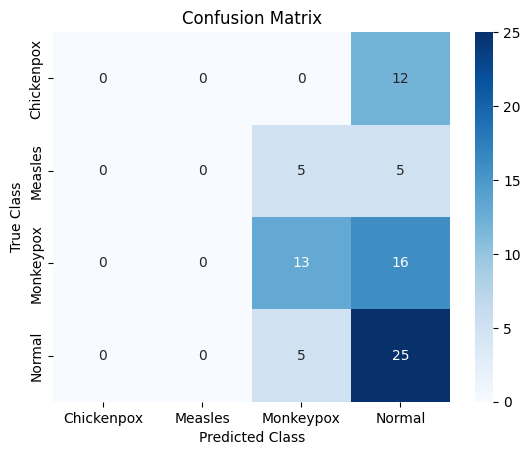

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Use the model to make predictions on the test data
y_pred = np.argmax(model.predict(test_dataset), axis=1)

# Create the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Create a list of class labels
class_names = ['Chickenpox', 'Measles', 'Monkeypox', 'Normal']

# Create a heatmap of the confusion matrix
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')

# Display the plot
plt.show()
